In [1]:
using DMRJtensor
include("su2_tools.jl");


In [2]:
# setup system spin and J
spinmag = 1.0;
Sx,Sy,Sz,Sp,Sm,O,Id = spinOps(spinmag)
Ns = 20 # number of sites

J_tensors = []
push!(J_tensors,[1.0, 1.0, 3.0])
push!(J_tensors,[ [2.0, 0.0, 1.0], [0.0, 2.0, 0.0], [0.0, 0.0, 2.0] ])
H_onesite, H_op_vec = H_SU2_Jtensor(spinmag, J_tensors) # make the onsite term

H_mpo = makeMPO(H_onesite,size(Id,1),Ns); # make the MPO!
psi0 = makePsi0(spinmag,Ns);
psi = copy(psi0)
println(psi[1])

printing regular tensor of type: tens{Complex{Float64}}
size = (1, 3, 1)
T = Complex{Float64}[0.386326944668528 + 0.4753993290566001im, 0.8429447861943558 + 0.35147084766429204im, 0.9387790138541219 + 0.9679956102077518im]



In [3]:
nOps = length(H_op_vec)
MPO_op_vec = []
for idx = 1:nOps
    MPO_here = makeMPO(H_op_vec[idx],size(Id,1),Ns);
    push!(MPO_op_vec, MPO_here)
end


In [4]:
# DMRG sweeps, with refinement 

nsweeps_m10 = 20
nsweeps_m40 = 10
nsweeps_m80 = 5

for i in 1:nsweeps_m10
    @time dmrg(psi, H_mpo, maxm = 10, cutoff = 1E-4)
end
println("coarse run completed")
variance = expect(psi,H_mpo,H_mpo)- (expect(psi, H_mpo))^2
println("variance is, ",variance)

for i in 1:nsweeps_m40
    @time dmrg(psi, H_mpo, maxm = 40, cutoff = 1E-8)
end
println("intermediate run completed")
for i in 1:nsweeps_m80
    @time dmrg(psi, H_mpo, maxm = 120, cutoff = 1E-15)
end
println("fine run completed")
variance = expect(psi,H_mpo,H_mpo)- (expect(psi, H_mpo))^2
println("variance is, ",variance)

 15.096006 seconds (45.25 M allocations: 2.259 GiB, 7.87% gc time)
  0.153540 seconds (81.64 k allocations: 115.924 MiB, 11.23% gc time)
  0.167758 seconds (81.64 k allocations: 115.924 MiB, 4.52% gc time)
  0.145440 seconds (81.33 k allocations: 115.566 MiB, 4.57% gc time)
  0.156372 seconds (80.80 k allocations: 115.212 MiB, 4.59% gc time)
  0.161656 seconds (80.54 k allocations: 115.208 MiB, 4.87% gc time)
  0.140069 seconds (80.48 k allocations: 115.207 MiB, 4.56% gc time)
  0.164375 seconds (80.48 k allocations: 115.207 MiB, 4.80% gc time)
  0.163249 seconds (80.48 k allocations: 115.207 MiB, 4.74% gc time)
  0.159452 seconds (80.48 k allocations: 115.207 MiB, 4.16% gc time)
  0.159918 seconds (80.48 k allocations: 115.207 MiB, 4.54% gc time)
  0.159176 seconds (80.48 k allocations: 115.207 MiB, 4.90% gc time)
  0.161908 seconds (80.48 k allocations: 115.207 MiB, 4.74% gc time)
  0.154983 seconds (80.48 k allocations: 115.207 MiB, 6.14% gc time)
  0.169018 seconds (80.48 k allocat

In [5]:
# evaluate Correlation matrix

corMat = zeros(ComplexF64,nOps,nOps)

op_expect = zeros(ComplexF64,nOps)

for idx = 1:nOps
    op_expect[idx] = expect(psi,MPO_op_vec[idx])
end

for idx1 = 1:nOps
    for idx2 = 1:idx1
        val_h = 0.5*expect(psi,MPO_op_vec[idx1],MPO_op_vec[idx2])
        val_h += 0.5*expect(psi,MPO_op_vec[idx2],MPO_op_vec[idx1])
        val_h += -(op_expect[idx1]*op_expect[idx2])
        corMat[idx1,idx2] = real(val_h)
        corMat[idx2,idx1] = real(val_h)
    end
end
display(corMat)
#display(findmax(broadcast(abs,broadcast(imag,corMat)))[1])

12×12 Array{Complex{Float64},2}:
   4.53733+0.0im    3.76754+0.0im  …  -0.830105+0.0im     2.70075+0.0im
   3.76754+0.0im    4.62941+0.0im     -0.818369+0.0im     2.77086+0.0im
  -2.30666+0.0im   -2.33806+0.0im      0.403641+0.0im    -1.83638+0.0im
  -2.27628+0.0im   -0.68096+0.0im      0.467051+0.0im   -0.782667+0.0im
 -0.361941+0.0im  -0.379114+0.0im     0.0847236+0.0im  -0.0569971+0.0im
 -0.792896+0.0im  -0.814441+0.0im  …   0.180982+0.0im    -0.46774+0.0im
 -0.361941+0.0im  -0.379114+0.0im     0.0847236+0.0im  -0.0569971+0.0im
 -0.720459+0.0im   -2.37407+0.0im      0.158216+0.0im   -0.850476+0.0im
 -0.830105+0.0im  -0.818369+0.0im      0.241332+0.0im   -0.496982+0.0im
 -0.792896+0.0im  -0.814441+0.0im      0.180982+0.0im    -0.46774+0.0im
 -0.830105+0.0im  -0.818369+0.0im  …   0.241332+0.0im   -0.496982+0.0im
   2.70075+0.0im    2.77086+0.0im     -0.496982+0.0im     1.88578+0.0im

In [117]:
writedlm(stdout, broadcast(x -> round(x,digits=2),(broadcast(real,corMat))) )

4.71	3.55	-2.61	-2.59	0.24	-1.65	0.24	-0.82	-1.98	-1.65	-1.98	3.03
3.55	4.43	-2.37	-0.73	0.17	-1.86	0.17	-2.53	-1.65	-1.86	-1.65	2.92
-2.61	-2.37	3.88	-0.21	-2.18	0.98	-2.18	-0.63	1.09	0.98	1.09	-2.2
-2.59	-0.73	-0.21	5.07	1.13	0.34	1.13	-1.79	1.17	0.34	1.17	-0.99
0.24	0.17	-2.18	1.13	-2.17	-0.56	6.01	1.23	0.43	0.48	-0.58	0.48
-1.65	-1.86	0.98	0.34	-0.56	-0.15	0.48	1.14	-0.14	1.92	1.68	-1.25
0.24	0.17	-2.18	1.13	6.01	0.48	-2.17	1.23	-0.58	-0.56	0.43	0.48
-0.82	-2.53	-0.63	-1.79	1.23	1.14	1.23	4.84	0.38	1.14	0.38	-1.01
-1.98	-1.65	1.09	1.17	0.43	-0.14	-0.58	0.38	-0.16	1.68	2.05	-1.3
-1.65	-1.86	0.98	0.34	0.48	1.92	-0.56	1.14	1.68	-0.15	-0.14	-1.25
-1.98	-1.65	1.09	1.17	-0.58	1.68	0.43	0.38	2.05	-0.14	-0.16	-1.3
3.03	2.92	-2.2	-0.99	0.48	-1.25	0.48	-1.01	-1.3	-1.25	-1.3	2.27


In [19]:
maximum(broadcast(abs,corMat - corMat'))
MPO_op_vec[3][2][3,:,:,2]

tens{Complex{Float64}}((2, 2), Complex{Float64}[0.5 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, -0.5 + 0.0im])

In [9]:
using LinearAlgebra
using Printf

#keep_idx = [1,2,3,4,8,12] # S_i and (S_ii)^2 operators only
keep_idx = 1:12 # all operators
corMat_reduced = corMat[keep_idx,keep_idx]
corMat_reduced = corMat;

vals,vecs = LinearAlgebra.eigen(corMat_reduced)
min_val, tar_idx = findmin(broadcast(abs,vals))
#min_val, tar_idx = findmin(broadcast(real,vals))

op_estimate = broadcast(real,vecs[:,tar_idx])/maximum(broadcast(abs,vecs[:,tar_idx]))

@printf("eigenvalues = ")
for val in vals
    @printf("%.8f ",real(val))
end
@printf("\n")

@printf("min_eig = %E \n",min_val)

@printf("operators = ")
for op in op_estimate
    @printf("%.3f ",op)
end
@printf("\n")

#J_tensors[1]


eigenvalues = -0.00000000 0.00000000 0.00000000 0.00000000 0.00688283 0.06936512 0.14034869 0.28067027 0.43104381 5.98135186 7.27185333 13.24225716 
min_eig = 5.427318E-17 
operators = 0.000 0.000 0.000 0.000 -1.000 -0.193 1.000 0.000 0.003 0.193 -0.003 0.000 


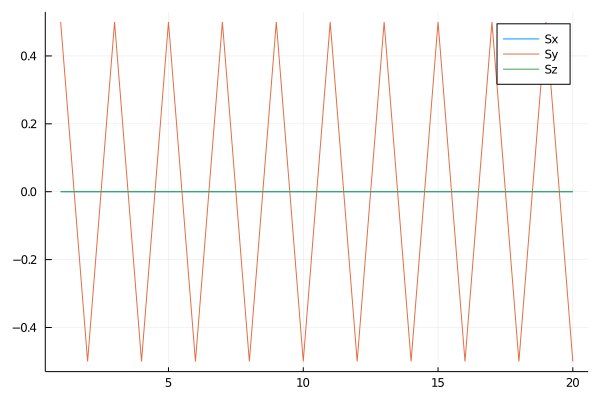

In [14]:
# Evaluate and plot the site-dependent magnetization
S_vals = zeros(ComplexF64,Ns,3)
S_ops = [Sx, Sy, Sz]

S0 = [Id O 
      O Id]
S0_mpo = Array{Array{ComplexF64,2},1}(undef,Ns)

for site = 1:Ns
   S0_mpo[site] = S0
end

for site = 1:Ns
    for op_idx = 1:3
        Sop_here = copy(S0_mpo)
        Sop_here[site] = [Id            O
                          S_ops[op_idx] Id]
        mpo_h = makeMPO(Sop_here,size(Id,1),Ns)
        S_vals[site,op_idx] = expect(psi,mpo_h)
    end
end

using Plots
plot(broadcast(real,S_vals[:,1]),label="Sx")
plot!(broadcast(real,S_vals[:,2]),label="Sy")
plot!(broadcast(real,S_vals[:,3]),label="Sz")

In [62]:
# test expectation operator

function expect_test(dualpsi ::MPS,psi::MPS,H::MPO...;
        Lbound ::TensType=typeof(psi[1])() ,
        Rbound ::TensType=Lbound ,order ::intvecType=intType[])
    Ns = size(psi ,1)
    #println(Ns)
    nMPOs = size(H,1)
    #println(nMPOs)
    #println(order)
    nLsize = nMPOs+2
    Lenv,Renv = makeEnds(dualpsi ,psi ,H..., Lbound=Lbound ,Rbound=Rbound)
    
    for i = 1: length(psi)
        Lenv =contractc(Lenv ,1,dualpsi[i],1)
        for j = 1:nMPOs
            Lenv =contract(Lenv ,[1, nLsize],H[j][i],[1,3])
        end 
        Lenv =contract(Lenv ,[1, nLsize],psi[i],[1,2])
    end
    
    if order  == intType[]
        permvec = vcat([ ndims(Renv)],[i for i = 2:ndims(Renv ) -1] ,[1])
        modRenv = permutedims(Renv ,permvec)
    else 
        modRenv = Renv 
    end 
    
return contract(Lenv, modRenv)
    
end

expect_test (generic function with 1 method)

In [103]:
#display( expect(psi,psi,MPO_op_vec[1],MPO_op_vec[1]) )
idx1 = 6;
idx2 = 12;
#display( expect(psi,MPO_op_vec[idx1],MPO_op_vec[idx2]) )
#display( expect(psi,MPO_op_vec[idx2],MPO_op_vec[idx1]) )
var1 = expect(psi,MPO_op_vec[idx1])
var2 = expect(psi,MPO_op_vec[idx2])
var1 = Complex(1,1);
var2 = Complex(1,1);
display( var1 )
display( var2 )

display( var1*var2' )

1 + 1im

1 + 1im

2 + 0im

In [94]:
testM = zeros(2,2);
testM[1,1] = 4.261;
testM[1,2] = -2.13;
testM[2,1] = testM[1,2];
testM[2,2] = 1.09
LinearAlgebra.eigen(testM)

In [27]:
### check Hermiticity of operators

# makes an initial MPS for spin s and size Ns
function plot_site_op(M)
    size_h = size(M)
    Nop_r = size_h[1];
    Nop_c = size_h[4];
    spin_stride = size_h[2];
    if (spin_stride != size_h[3])
       throw("Spin matrix not square!") 
    end
    for op_r = 1:Nop_r
        for r = 1:spin_stride
            for op_l = 1:Nop_c
                for c = 1:spin_stride
                    val_h = M[op_r,r,c,op_l]
                    val_r = real(val_h)
                    val_i = imag(val_h)
                    @printf("%.1f",val_r)
                    if (val_i >= 0)
                        @printf("+%.1fi",val_i)
                    else
                        @printf("-%.1fi",-val_i)                       
                    end

                    print(" ")
                end
                print("|| ")
            end
            print("\n")
        end
        print("-------------------------- || -------------------------- || -------------------------- || \n")
    end
    
end

op_h = MPO_op_vec[5];
site_h = 2; # 1,Ns sites, 1 and Ns are 1xNxNx3
site_op = op_h[site_h]
size(site_op)
plot_site_op(site_op)
# Sx, Sy, Sz || Sx Sx, Sx Sy ...
Sx*Sy*Sx

1.0+0.0i 0.0+0.0i 0.0+0.0i || 0.0+0.0i 0.0+0.0i 0.0+0.0i || 0.0+0.0i 0.0+0.0i 0.0+0.0i || 
0.0+0.0i 1.0+0.0i 0.0+0.0i || 0.0+0.0i 0.0+0.0i 0.0+0.0i || 0.0+0.0i 0.0+0.0i 0.0+0.0i || 
0.0+0.0i 0.0+0.0i 1.0+0.0i || 0.0+0.0i 0.0+0.0i 0.0+0.0i || 0.0+0.0i 0.0+0.0i 0.0+0.0i || 
-------------------------- || -------------------------- || -------------------------- || 
0.0+0.0i 0.0+0.0i 0.0-0.5i || 0.0+0.0i 0.0+0.0i 0.0+0.0i || 0.0+0.0i 0.0+0.0i 0.0+0.0i || 
0.0+0.0i 0.0+0.0i 0.0+0.0i || 0.0+0.0i 0.0+0.0i 0.0+0.0i || 0.0+0.0i 0.0+0.0i 0.0+0.0i || 
0.0+0.5i 0.0+0.0i 0.0+0.0i || 0.0+0.0i 0.0+0.0i 0.0+0.0i || 0.0+0.0i 0.0+0.0i 0.0+0.0i || 
-------------------------- || -------------------------- || -------------------------- || 
0.0+0.0i 0.0+0.0i 0.0+0.0i || 0.0+0.0i 0.0+0.0i 0.0-0.5i || 1.0+0.0i 0.0+0.0i 0.0+0.0i || 
0.0+0.0i 0.0+0.0i 0.0+0.0i || 0.0+0.0i 0.0+0.0i 0.0+0.0i || 0.0+0.0i 1.0+0.0i 0.0+0.0i || 
0.0+0.0i 0.0+0.0i 0.0+0.0i || 0.0+0.5i 0.0+0.0i 0.0+0.0i || 0.0+0.0i 0.0+0.0i 1.0+0.0i || 

3×3 Array{Complex{Float64},2}:
 0.0+0.0im  0.0-2.29935e-17im  0.0+0.0im
 0.0+0.0im  0.0+0.0im          0.0+0.0im
 0.0+0.0im  0.0-2.29935e-17im  0.0+0.0im